Traffic Sign Classification

This notebook showcases the developed Traffic Sign Recognition model, over the GTSRB - German Traffic Sign dataset, using PyTorch. The goal is to provide a clear way to visualize and explain the code. This way, we'll go over multiple sections:

    1) Data Profiling
    2) Data Preparation
    3) Model Definition and Profiling
    4) Training
    5) Evaluation

1) Data Profiling:

Loading serialized data for data profiling, using pickle since JSON creates much larger file sizes. Images are set to 32 by 32 pixels, with 3 channels.

In [4]:
import codecs, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle

num_classes = 43
IMAGE_SIZE = 32

# Loading data for visualization
train_data = pickle.load(open("serialized_data/train_data_numpy", "rb"))
train_labels = pickle.load(open("serialized_data/train_labels_numpy", "rb"))
test_data = pickle.load(open("serialized_data/test_data_numpy", "rb"))

# Loading number-to-name label conversion json
label_json = codecs.open("DataProfiling/label_names.json", 'r', encoding='utf-8').read()
label_names = json.loads(label_json)

Dataset statistics and preview:


Shape of training data:  (39209, 32, 32, 3)
Shape of test data:  (12630, 32, 32, 3)
Number of classes: 43
Images resized to 32 x 32


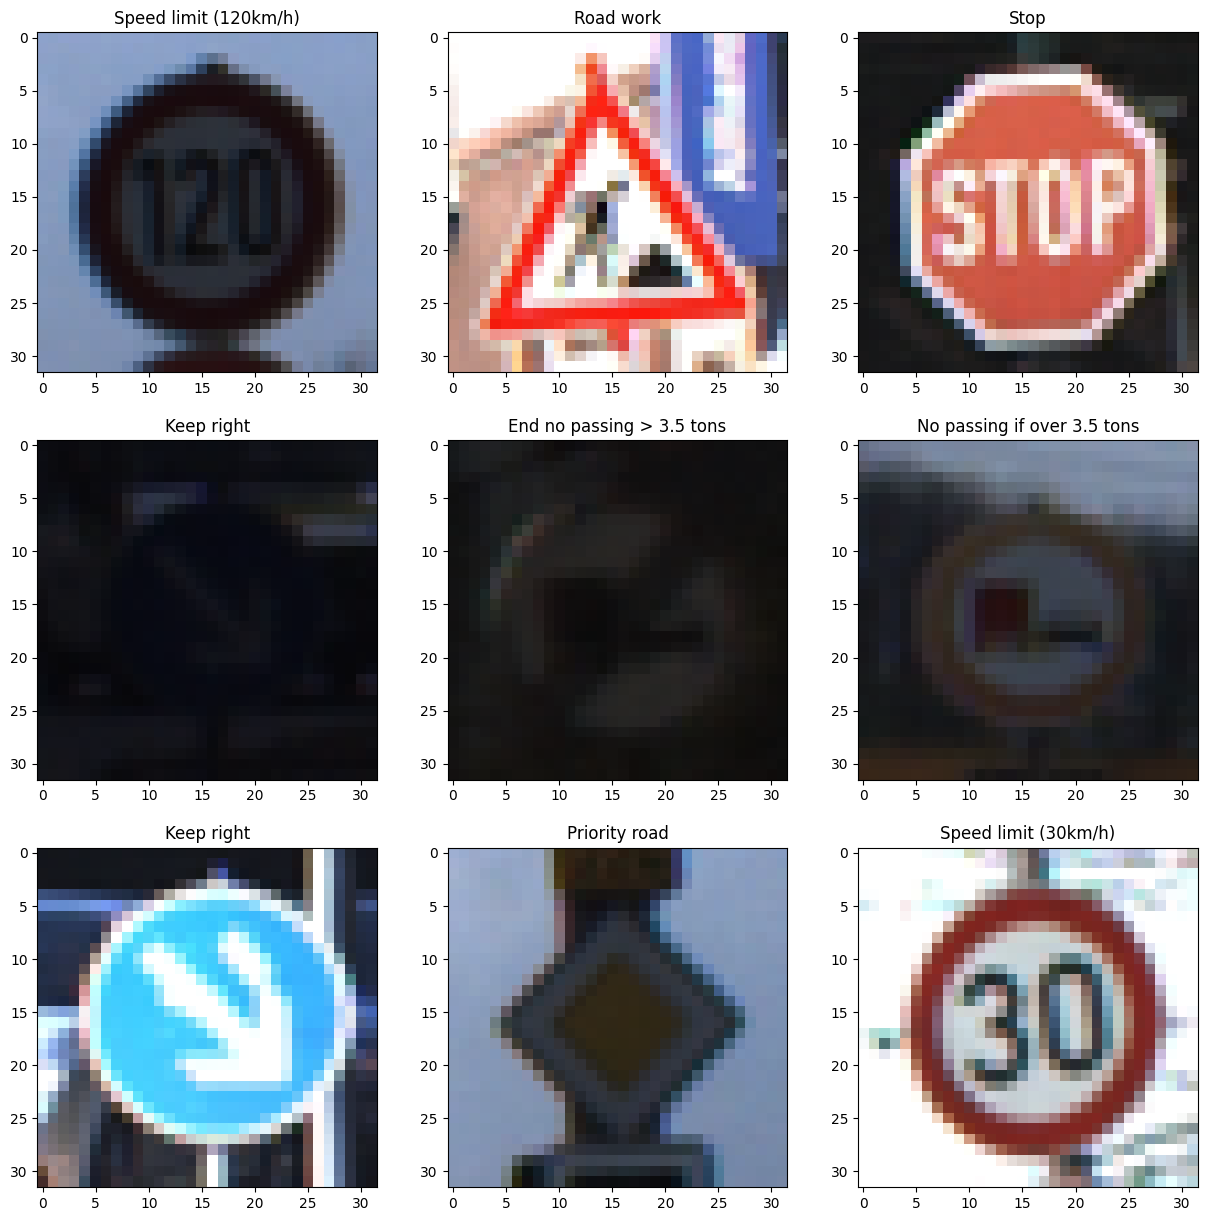

In [5]:
print("\nShape of training data: ", train_data.shape)
print("Shape of test data: ", test_data.shape)
print(f"Number of classes: {num_classes}")
print(f"Images resized to {IMAGE_SIZE} x {IMAGE_SIZE}")

# Plotting random train set examples
plot_size = 3
random_idxs = [random.randint(0, train_data.shape[0]) for i in range(plot_size**2)]
fig = plt.figure(figsize=(15, 15))
for i, index in enumerate(random_idxs):
    a=fig.add_subplot(plot_size,plot_size, i+1)
    imgplot = plt.imshow(train_data[index])
    a.set_title(label_names[str(train_labels[index]+1)])
plt.show()

The dataset in heavily unbalanced, with some classes having only around 200 instances and others having more than 2000, as be seen in the class distribution histogram below. This issue can have a significant impact on model performance and is addressed through data augmentation and oversampling .

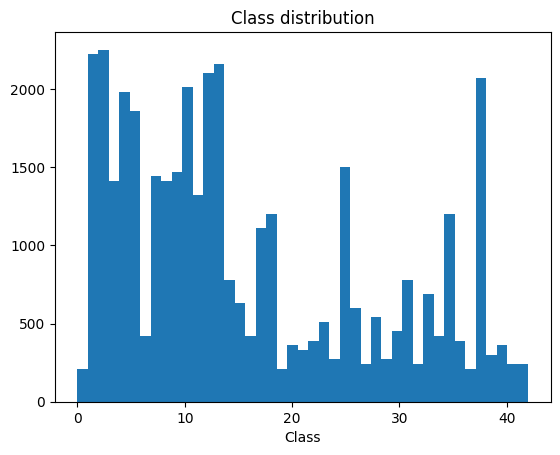

In [6]:
fig, ax = plt.subplots()
values, bins, patches = ax.hist(train_labels, num_classes)
ax.set_xlabel('Class')
ax.set_title('Class distribution')
plt.show()

2) Data Preparation:

A data preparation will be developed once the evaluation for the model is complete, consisting of data augmentation, SMOTE oversampling, and CLAHE implementation.

3) Model Definition and Profiling:

The architecture of the model is loosely based on [AlexNet](https://en.wikipedia.org/wiki/AlexNet), consisting of multiple convolution layers, some followed by max pooling, and mostly using the [ELU](https://deeplearninguniversity.com/elu-as-an-activation-function-in-neural-networks/) activation function. This is followed by a fully connected network, with 2 hidden layers (using RELU) and dropout regularization with p=0.5 to reduce overfitting. Multiple hypermeter variations were tested, with the current one leading to the best performance.

In [7]:
import torch.nn as nn

class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=320, kernel_size=3,padding=1),
            nn.ELU(inplace=True),
            nn.Conv2d(in_channels=320, out_channels=256, kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(inplace=True),
        )
        
        self.classification = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(16*256, 600),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=600, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        X = self.conv(x)
        X = X.view(X.shape[0], -1)
        Y = self.classification(X)
        return Y

4) Training:

To train the model, cross entropy loss showed the best results, using adam optimization for efficiency with a constant learning rate of 0.001. The batch size chosen is 256 examples.

In [8]:
from model import TrafficSignCNN
from torch import optim, nn, save
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from matplotlib.pyplot import Axes, gca, figure, savefig
from torch.utils.data import DataLoader
import pickle

# Loading training dataset
train_set = pickle.load(open("serialized_data/train_data_loader", "rb"))

# Parameters 
num_classes = 43
batch_size = 256
learning_rate = 0.001
EPOCHS = 15

# Train function
def train(model, train_set, optimizer, criterion):
    epoch_ls = 0
    epoch_acc = 0
    model.train()
    for batch_idx, (x, y) in enumerate(train_set):
        optimizer.zero_grad()
        y_pred= model(x)
        loss = criterion(y_pred,y)
        loss.backward()
        final_pred = y_pred.argmax(axis=1)
        accuracy = accuracy_score(final_pred,y)
        optimizer.step()
        epoch_ls += loss.item()
        epoch_acc += accuracy
    return epoch_ls / len(train_set), epoch_acc / len(train_set)

# Initializing CNN, Loss function, and optimizer
model = TrafficSignCNN(num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
transform = transforms.ToTensor()

# Main training logic
train_loss = []
train_accuracy = []
for epoch in range(EPOCHS):
    print("Epoch: ",epoch)
    train_ls, train_acc = train(model, train_set, optimizer, criterion)
    train_loss.append(train_ls)
    train_accuracy.append(train_acc)
    print("Loss: ",train_ls)
    print("Accuracy: ",train_acc)

Epoch:  0
Loss:  2.654373432134653
Accuracy:  0.24309136937757364
Epoch:  1
Loss:  0.851258492895535
Accuracy:  0.7126499643649034
Epoch:  2
Loss:  0.24702461596046174
Accuracy:  0.9172207841700981
Epoch:  3
Loss:  0.12938133755384326
Accuracy:  0.9583632354687994
Epoch:  4
Loss:  0.08448511838622681
Accuracy:  0.9729606331168831
Epoch:  5
Loss:  0.06906516529474553
Accuracy:  0.97823042049414
Epoch:  6
Loss:  0.05736920647565034
Accuracy:  0.9815978133908774
Epoch:  7
Loss:  0.05651303778958882
Accuracy:  0.9826439756889451
Epoch:  8
Loss:  0.046738718311278175
Accuracy:  0.986226663961039
Epoch:  9
Loss:  0.05010304947129705
Accuracy:  0.9848823051948052
Epoch:  10
Loss:  0.04165365624048009
Accuracy:  0.9874380097798543
Epoch:  11
Loss:  0.042069750029122
Accuracy:  0.9879007711038961
Epoch:  12
Loss:  0.041477253664339374
Accuracy:  0.988484172077922
Epoch:  13
Loss:  0.0373800162047559
Accuracy:  0.988864650974026
Epoch:  14
Loss:  0.03106833060609189
Accuracy:  0.990817775974026


Plotting loss and accuracy over time:

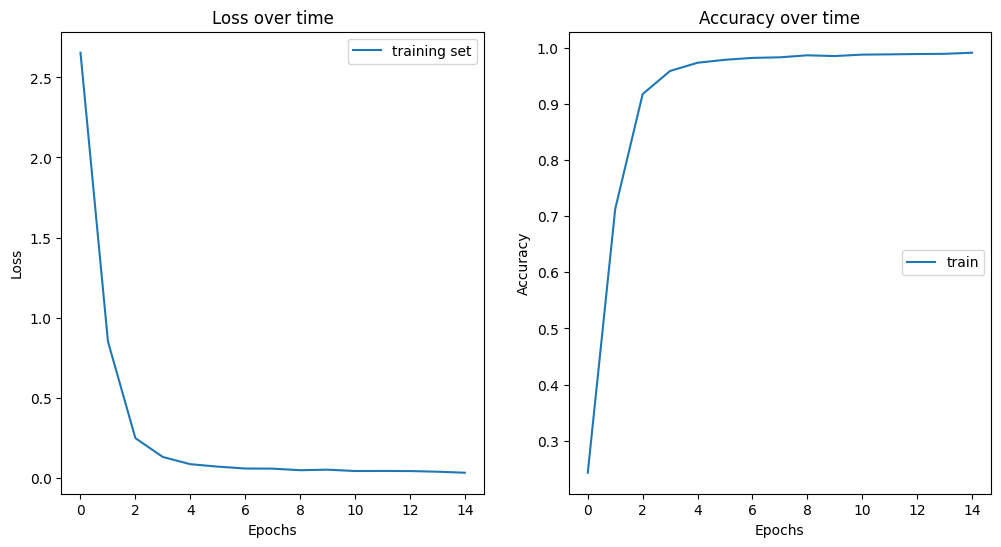

In [9]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(train_loss, label="training set")
axs[0].set_title("Loss over time")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right')
axs[1].plot(train_accuracy, label="train")
axs[1].set_title("Accuracy over time")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right')
plt.show()

A training accuracy of 0.99 is achieved in just 15 epochs. The loss reaches a very small values within just a few iterations, finishing at 0.031. 

5) Evaluation:

The test set evaluation of the model reaches an accuracy of 0.95, correctly classifying 12044 images:

In [10]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import torch

# Loading test dataset
test_set = pickle.load(open("serialized_data/test_data_loader", "rb"))

true_labels = []
pred_labels = []

# Testing
with torch.no_grad():
    model.eval()
    y_right = 0
    for idx, (x, y) in enumerate(test_set):
        y_pred = model(x)
        final_pred = y_pred.argmax(axis=1)
        if y.item() == final_pred.item():
            y_right += 1
        pred_labels.append(final_pred.item())
        true_labels.append(y.item())

print(f"Correctly classified images: {y_right}")
print(f"Incorrectly classified images: {len(test_set)-y_right}")
print(f"Final Model Accuracy: {y_right/len(test_set)}")
print(classification_report(true_labels,pred_labels))

Correctly classified images: 12044
Incorrectly classified images: 586
Final Model Accuracy: 0.9536025336500396
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        60
           1       0.96      0.97      0.97       720
           2       0.96      0.99      0.97       750
           3       0.96      0.87      0.92       450
           4       0.98      0.97      0.98       660
           5       0.91      0.96      0.94       630
           6       0.99      0.90      0.94       150
           7       0.93      0.93      0.93       450
           8       0.94      0.95      0.94       450
           9       0.98      0.97      0.98       480
          10       0.98      1.00      0.99       660
          11       0.91      0.97      0.94       420
          12       0.99      0.96      0.97       690
          13       0.98      1.00      0.99       720
          14       0.99      1.00      0.99       270
          15       0.98 

Confusion Matrix: 

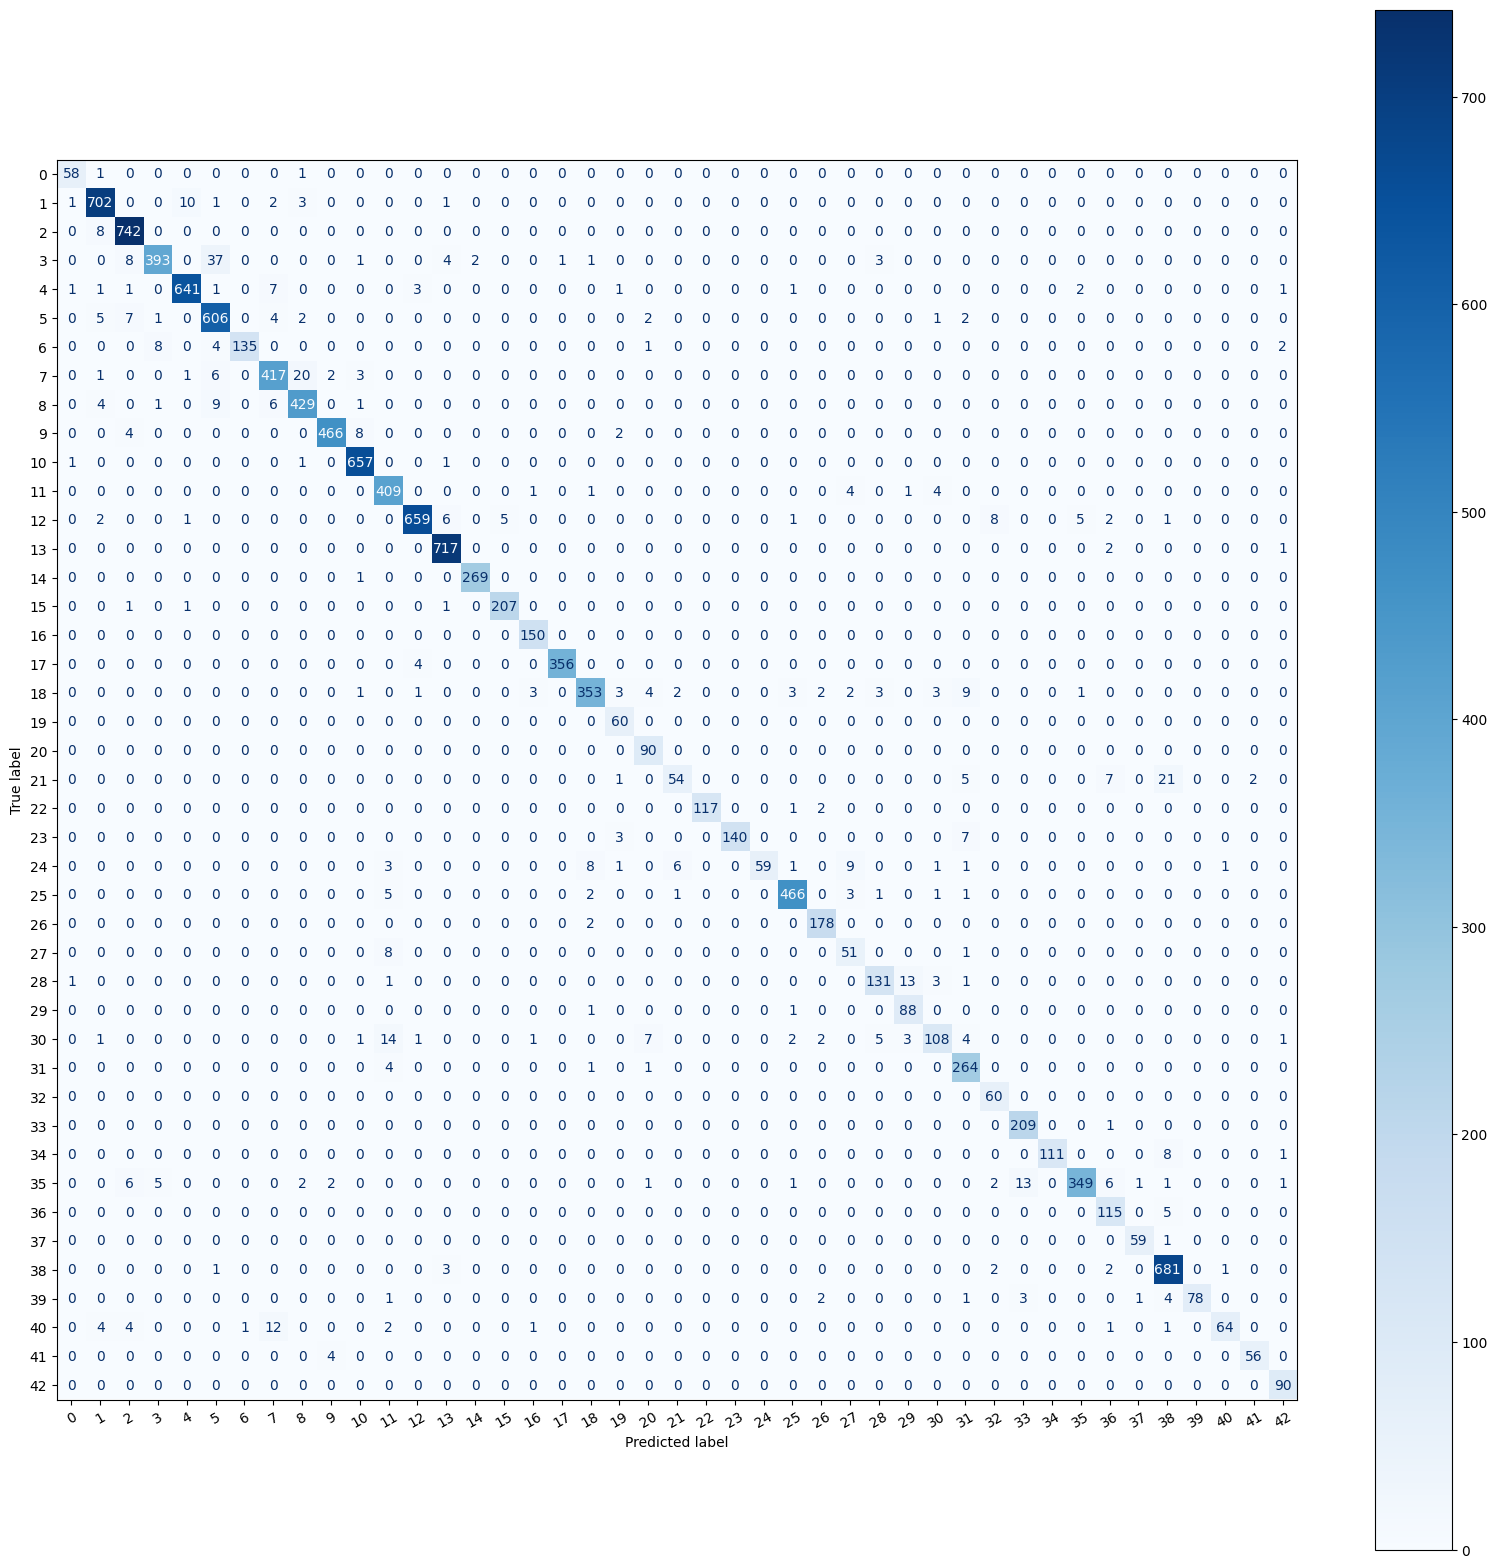

In [11]:
fig = plt.figure(figsize = (20, 20));
ax = fig.add_subplot(1, 1, 1);
cm = confusion_matrix(true_labels, pred_labels);
cm = ConfusionMatrixDisplay(cm, display_labels = range(0, num_classes));
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.xticks(rotation = 30)
plt.show()

To show some examples of predictions, randomly selected images and results are presented:

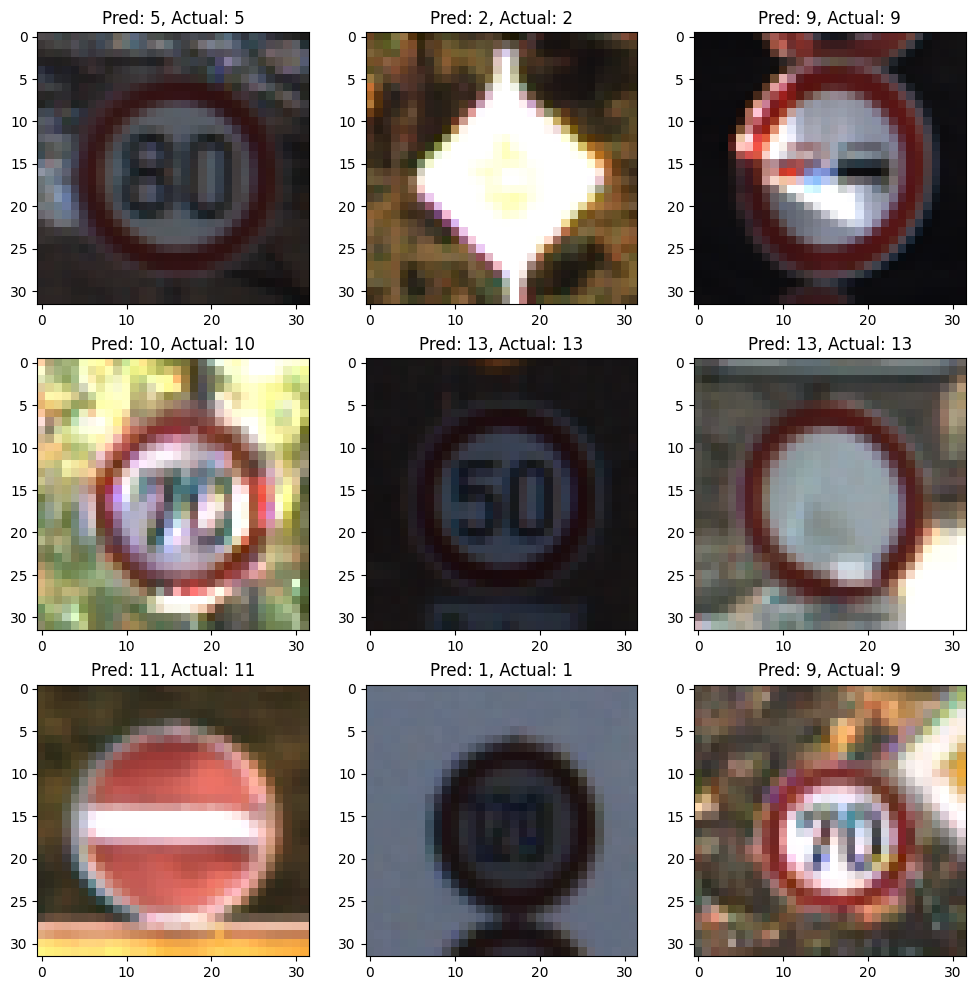

In [14]:
from random import randrange

# Getting random images
num_imgs = 9
random_idxs = [randrange(0,len(test_set)) for i in range(num_imgs)]
imgs = [test_set.dataset.__getitem__(random_idxs[i])[0] for i in range(num_imgs)]

# Calculating plot grid
HEIGHT = 4
NR_COLUMNS = 3
grid = (1,num_imgs)
if num_imgs > NR_COLUMNS:
    grid = (num_imgs // NR_COLUMNS, NR_COLUMNS) if num_imgs % NR_COLUMNS == 0 else (num_imgs // NR_COLUMNS + 1, NR_COLUMNS)

# Plotting images with respective class and prediction
i, j = 0, 0
fig, axs = plt.subplots(grid[0],grid[1],figsize=(grid[1]*HEIGHT,grid[0]*HEIGHT))
for n in range(num_imgs):
    img = imgs[n]
    axs[i, j].imshow(img.permute(1, 2, 0))
    title = f"Pred: {pred_labels[random_idxs[n]]}, Actual: {true_labels[random_idxs[n]]}"
    axs[i, j].set_title(title, fontsize=12)
    i, j = (i + 1, 0) if (n+1) % grid[1] == 0 else (i, j + 1)